In [ ]:
#from fastai.basics           import *
from fastai2.medical.imaging  import *
from fastai2.vision.all import *


In [ ]:
path = Path('CSV_files/data')
df = pd.read_csv('CSV_files/final.csv', header= None)
df.head()

,0,1
0,1.3.12.2.1107.5.1.4.67089.30000020032009581583400060156.dcm,covid
1,1.3.12.2.1107.5.1.4.67089.30000020032009581583400060157.dcm,covid
2,1.3.12.2.1107.5.1.4.67089.30000020032009581583400060158.dcm,covid
3,1.3.12.2.1107.5.1.4.67089.30000020032009581583400060159.dcm,covid
4,1.3.12.2.1107.5.1.4.67089.30000020032009581583400060160.dcm,covid


In [ ]:
blocks = (ImageBlock(cls=PILDicom),
                CategoryBlock)

getters = [
           ColReader(0, pref=path),
           ColReader(1)
]


In [ ]:
test = DataBlock(blocks=blocks, 
                   getters = getters,
                   splitter=RandomSplitter(0.05)
)

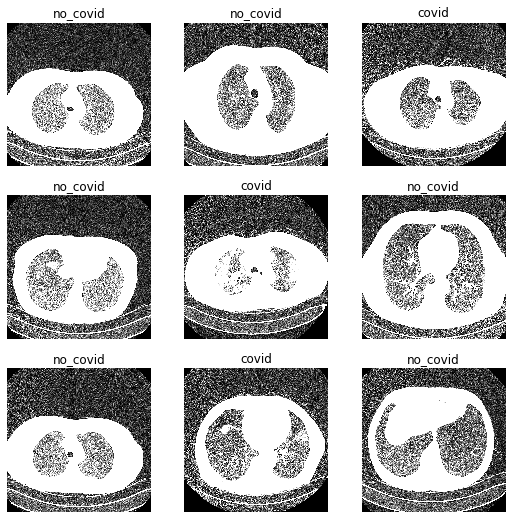

In [ ]:
dls = test.dataloaders(df)
dls.show_batch()

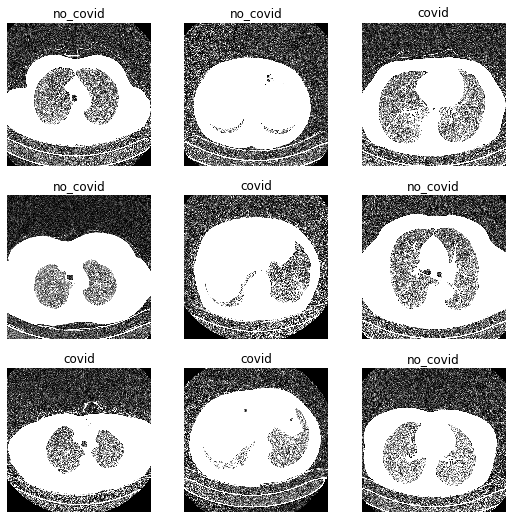

In [ ]:
import gc
learn = None
gc.collect()
torch.cuda.empty_cache()

bs = 64
item_tfms = Resize(224)
batch_tfms = [*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)]

covid = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
splitter=RandomSplitter(0.2,seed=24),
get_x=lambda x:path/f"{x[0]}",
get_y=lambda x:x[1],
                 )#, batch_tfms=batch_tfms)#, item_tfms=item_tfms)
             #  )
         

dls = covid.dataloaders(df)
dls.show_batch()

In [ ]:
learn = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy, cbs = ShowGraphCallback()).to_fp16()


In [ ]:
learn.load('resnet50_99')

In [ ]:
learn.export(fname='v2_no_val')

epoch,train_loss,valid_loss,accuracy,time
0,0.303180,0.260568,1.000000,00:19
1,0.293462,0.287084,0.990719,00:19
2,0.288894,0.242665,1.000000,00:19
3,0.272042,0.220656,1.000000,00:19
4,0.257105,0.210180,1.000000,00:19
5,0.247794,0.208539,1.000000,00:19
6,0.239158,0.206995,1.000000,00:19
7,0.236680,0.206678,1.000000,00:19


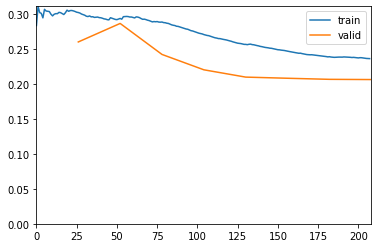

In [ ]:
learn.fit_one_cycle(8, max_lr=slice(0.2e-2,1e-2))#, pct_start=0.0, 
   # div_factor=100)

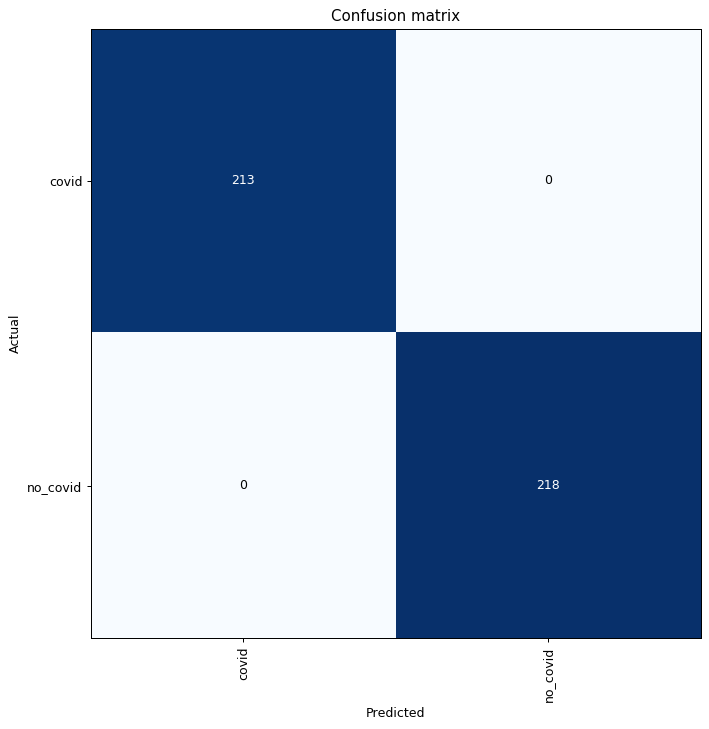

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix(figsize=(8,8), dpi=90)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))


In [ ]:
interp.most_confused(min_val=3)

('covid', tensor(0), tensor([0.6179, 0.3821]))

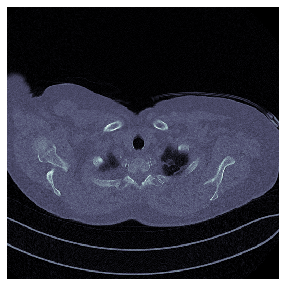

In [ ]:
test = Path('CSV_files')
fname = test/'test_set/corads1/6003602852/1.3.12.2.1107.5.1.4.67089.30000020051106565650400039349.dcm'
dcm = fname.dcmread()
dcm.show(scale=False)
learn.predict(fname)

In [ ]:
!ls test/'test_set/corads1

/bin/sh: 1: Syntax error: Unterminated quoted string


In [ ]:
preds = []
pred_dir= test/'test_set/corads1/6003607799'
for f in Path(pred_dir).iterdir():
    _,x,_ = learn.predict(f)
    preds.append(int(x))

TypeError: unsupported operand type(s) for /: 'DataBlock' and 'str'

In [ ]:
print('covid:',preds.count(0), 'no_covid:',preds.count(1), 'ratio:',preds.count(0)/(preds.count(0)+preds.count(1)))

covid: 8 no_covid: 97 ratio: 0.0761904761904762


In [ ]:
learn.predict(fname)

('covid', tensor(0), tensor([0.9179, 0.0821]))

In [ ]:
from fastai2.vision.widgets import * 
cleaner = ImageClassifierCleaner(learn)
cleaner

/home/mlemsalu/miniconda3/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


IndexError: list index out of range

In [ ]:
learn.save('resnet50')

In [ ]:
learn.export('restnet50_99.pkl')

PicklingError: Can't pickle <function <lambda> at 0x7fe338033950>: attribute lookup <lambda> on __main__ failed

#### Remove 10-20% of the beginning and end of a CT scan?

#### Possible to get one DICOM per CT scan? 

#### Discuss server architecture

In [ ]:
#accuracy of 90% with the following::: learn = cnn_learner(dls, resnet50,  loss_func=LabelSmoothingCrossEntropy(), metrics=error_rate, cbs = ShowGraphCallback())
learn = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(), metrics=error_rate, cbs = ShowGraphCallback()).to_fp16()

learn.freeze()
learn.fit_one_cycle(10, 5e-2)

In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained("efficientnet-b0")
num_ftrs = model._fc.in_features

# Replace the last fully connected layer with our own layers, I add in an additional Dropout layer for some regularizing effects
model._fc = nn.Sequential(nn.Linear(num_ftrs, 1000),
                              nn.ReLU(),
                              nn.Dropout(),
                              nn.Linear(1000, dls.c))

In [ ]:
opt_func = partial(Adam)
loss_func = LabelSmoothingCrossEntropy()
metrics = [accuracy]
learn = Learner(dls, model, opt_func=opt_func, loss_func=loss_func, metrics=metrics).to_fp16() # run to check if GPU is enabled

In [ ]:
learn.fine_tune(5, 1e-3)

In [ ]:
learn.fit_one_cycle(25, lr_max=1e-5)

In [ ]:
#dls = covid.dataloaders(df.sample(992), bs=16)
dls = dls.cuda()


In [ ]:
roc = RocAuc()
dls.c
model = xresnet18_deeper(n_out=dls.c)

In [ ]:
#accuracy of 90% with the following::: learn = cnn_learner(dls, resnet50,  loss_func=LabelSmoothingCrossEntropy(), metrics=error_rate, cbs = ShowGraphCallback())
learn = cnn_learner(dls, resnet50, metrics=error_rate, cbs = ShowGraphCallback())

learn.freeze()
learn.fit_one_cycle(1, 5e-2)

In [ ]:

learn.freeze()
learn.fit_one_cycle(1, 5e-2)


In [ ]:


set_seed(77)
learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy,
                cbs = ShowGraphCallback())



In [ ]:


learn.freeze()
learn.fit_one_cycle(10, 5e-2)



In [ ]:
learn.unfreeze()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix(figsize=(8,8), dpi=90)

In [ ]:
learn.fit_flat_cos(7,slice(1e-6,1e-4))

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)


In [ ]:
learn.fit_one_cycle(5)


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))


In [ ]:
dls = test.dataloaders(df)



In [ ]:
dls = dblock.dataloaders(path)

dls.show_batch()


In [ ]:
#dls.show_batch()
#https://github.com/fastai/fastai2/tree/master/nbs/course

In [ ]:
fname = path/'train/covid/1.3.12.2.1107.5.1.4.67089.30000020032608490724900083403.dcm'
dcm = fname.dcmread()
dcm.show(scale=False)

In [ ]:
items = get_dicom_files(path, recurse=True)

### Check for duplicates

In [ ]:
def DicomSplit(valid_pct=0.2, seed=None, **kwargs):
    "Splits `items` between train/val with `valid_pct`"
    "and checks if identical patient IDs exist in both the train and valid sets"
    def _inner(o, **kwargs):
        train_list=[]; valid_list=[]
        if seed is not None: torch.manual_seed(seed)
        rand_idx = L(int(i) for i in torch.randperm(len(o)))
        cut = int(valid_pct * len(o))
        trn = rand_idx[cut:]; trn_p = o[rand_idx[cut:]]
        val = rand_idx[:cut]; val_p = o[rand_idx[:cut]]
        
        for i, im in enumerate(trn_p):
            trn = im.dcmread()
            patient_ID = trn.PatientID
            train_list.append(patient_ID)
        for j, jm in enumerate(val_p):
            val = jm.dcmread()
            vpatient_ID = val.PatientID
            valid_list.append(vpatient_ID) 
        print(set(train_list) & set(valid_list))
        return rand_idx[cut:], rand_idx[:cut]
    return _inner

In [ ]:
#updating to accomodate 
def _dcm2dict2(fn, **kwargs): 
        t = fn.dcmread()
        return fn, t.PatientID, t.PatientAge, t.PatientSex, t.BodyPartExamined, t.Modality, t.Rows, t.Columns, t.BitsStored, t.PixelRepresentation

@delegates(parallel)
def _from_dicoms2(cls, fns, n_workers=0, **kwargs):
    return pd.DataFrame(parallel(_dcm2dict2, fns, n_workers=n_workers, **kwargs))
pd.DataFrame.from_dicoms2 = classmethod(_from_dicoms2)

In [ ]:
test_df = pd.DataFrame.from_dicoms2(items)
test_df.columns=['file', 'PatientID', 'Age', 'Sex', 'Bodypart', 'Modality', 'Rows', 'Cols', 'BitsStored', 'PixelRep' ]
test_df.to_csv('test_df.csv')
test_df.head()

In [ ]:
def DataSplit(valid_pct=0.2, seed=None, **kwargs):
    "Check the number of each class in train and valid sets"
    def _inner(o, **kwargs):
        train_list=[]; valid_list=[]
        if seed is not None: torch.manual_seed(seed)
        rand_idx = L(int(i) for i in torch.randperm(len(o)))
        cut = int(valid_pct * len(o)) 
        trn_p = o[rand_idx[cut:]]
        val_p = o[rand_idx[:cut]]
        
        for p in enumerate(trn_p):
            b = str(p).split('/')[7]
            train_list.append(b)
        for q in enumerate(val_p):
            e = str(q).split('/')[7]
            valid_list.append(e)
        print(f'train: {train_list}\n valid: {valid_list}')
        return rand_idx[cut:], rand_idx[:cut]
    return _inner

In [ ]:
def DataSplit(valid_pct=0.2, seed=None, **kwargs):
    "Check the number of each class in train and valid sets"
    def _inner(o, **kwargs):
        train_list=[]; valid_list=[]
        if seed is not None: torch.manual_seed(seed)
        rand_idx = L(int(i) for i in torch.randperm(len(o)))
        cut = int(valid_pct * len(o)) 
        trn_p = o[rand_idx[cut:]]
        val_p = o[rand_idx[:cut]]
        
        for p in enumerate(trn_p):
            b = str(p).split('/')[7]
            train_list.append(b)
        for q in enumerate(val_p):
            e = str(q).split('/')[7]
            valid_list.append(e)
        print(f'train: {train_list}\n valid: {valid_list}')
        return rand_idx[cut:], rand_idx[:cut]
    return _inner

In [ ]:
dcm.show(scale=dicom_windows.subdural)


In [ ]:
px = dcm.scaled_px.flatten()
plt.hist(px, bins=40);

In [ ]:
bins = px.freqhist_bins(20)
print(bins)
plt.hist(px, bins=bins);

In [ ]:
plt.plot(bins, torch.linspace(0,1,len(bins)));


In [ ]:
plt.imshow(dcm.hist_scaled());


In [ ]:
dcm.show()


In [ ]:
dcm.show(cmap=plt.cm.gist_ncar, figsize=(6,6))


In [ ]:
mask = dcm.mask_from_blur(dicom_windows.lungs)
wind = dcm.windowed(*dicom_windows.lungs)

_,ax = subplots(1,1)
show_image(wind, ax=ax[0])
show_image(mask, alpha=0.5, cmap=plt.cm.Reds, ax=ax[0]);

In [ ]:
bbs = mask2bbox(mask)
lo,hi = bbs
show_image(wind[lo[0]:hi[0],lo[1]:hi[1]]);

In [ ]:
def fix_pxrepr(dcm):
    if dcm.PixelRepresentation != 0 or dcm.RescaleIntercept<-100: return
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000
def dcm_tfm(fn): 
    fn = (path/fn).with_suffix('.dcm')
    try:
        x = fn.dcmread()
        fix_pxrepr(x)
    except Exception as e:
        pass
    if x.Rows != 512 or x.Columns != 512: x.zoom_to((512,512))
    px = x.scaled_px
    return TensorImage(px.to_3chan(dicom_windows.brain,dicom_windows.subdural, bins=None))

In [ ]:
px = dcm.windowed(*dicom_windows.brain)
show_image(px);

In [ ]:
_,axs = subplots(1,2)
dcm.show(ax=axs[0]);   dcm.show(dicom_windows.brain, ax=axs[1])

In [ ]:
gdcm = gauss_blur2d(dcm.windowed(*dicom_windows.brain), 100)
show_image(gdcm);


In [ ]:
show_image(gdcm>0.15);


In [ ]:
show_image(dcm.mask_from_blur(dicom_windows.brain), cmap=plt.cm.Reds, alpha=0.6);


In [ ]:
def pad_square(x):
    r,c = x.shape
    d = (c-r)/2
    pl,pr,pt,pb = 0,0,0,0
    if d>0: pt,pd = int(math.floor( d)),int(math.ceil( d))        
    else:   pl,pr = int(math.floor(-d)),int(math.ceil(-d))
    return np.pad(x, ((pt,pb),(pl,pr)), 'minimum')

def crop_mask(x):
    mask = x.mask_from_blur(dicom_windows.brain)
    bb = mask2bbox(mask)
    if bb is None: return
    lo,hi = bb
    cropped = x.pixel_array[lo[0]:hi[0],lo[1]:hi[1]]
    x.pixel_array = pad_square(cropped)
_,axs = subplots(1,2)
dcm.show(ax=axs[0])
crop_mask(dcm)
dcm.show(ax=axs[1]);

![Screenshot%20from%202020-07-29%2010-24-10.png](attachment:Screenshot%20from%202020-07-29%2010-24-10.png)